В докладе речь идет о новой архитектуре HRM (Hierarchy Reasoning Model, https://arxiv.org/abs/2506.21734), 
вдохновленной результатами нейробиологии.
Цель - продвинуться в решении логических задач, 
с которыми LLM справляются с околонулевым результатом.

Литературный пересказ статьи (рекомендую к прочтению) от автора https://ru.wikipedia.org/wiki/Николенко,_Сергей_Игоревич
https://www.sergeynikolenko.ru/blog/hierarchical-reasoning-model

Очень краткое содержание моего доклада:

Оказывается, в мозгу есть нейронные связи как минимум двух типов:
1. Быстрое мышление (зрение слух, моторика)
2. Медленное мышление (абстракции, аналогии, планирование)

Они моделируются в работе двумя трансформерами энкодерами 
(https://github.com/fufaevvlvl/2025_08_Transformers_Week/blob/main/Day_2.ipynb).
Плюс линейные слои на входе и выходе.

Пасхалка: оказывается, что авторы взяли для ускорения вычислений
Attention механизм типа Flash, который тоже имеет дело с быстрой и медленной памятью,
но видеокарты
(https://github.com/fufaevvlvl/2025_08_Transformers_Week/blob/main/Day_4.ipynb)

Самым интересным являются биологические инсайты 
1. (Трюк 1) - собственно, моделирование двух систем в мозге:
при обучении быстрая модель делает T шагов, затем медленная 
получает информацию от быстрой и обновляется, процесс повторяется 
пока медленная модель не обучится N раз.
2. (Трюк 2) - мозг, в отличие от нейросети, не хранит все градиенты.
Можно записать формулу обновления состояния модели в окрестности 
точки экстремума, и можно обосновать, что первые приближения
дают удовлетворительный результат (с помощью теоремы о неявной функции).
Это сокращает число используемой памяти с O(T) до O(1).
3. (Трюк 3) - мозг в процессе решения задачи выделяет столько памяти, 
сколько нужно. Этот эффект моделируется Марковским процессом,
который решает, забрать награду сейчас, 
или рискнуть и сделать на инференсе еще один прогон медленной модели.

Ну еще авторы позаимствовали для своей модели целую кучу 
инженерных трюков (Rotary Positional Encoding, Gated Linear Units,
RMSNorm...), на каждый из которых можно написать отдельный обзор.

Результат логический/логичный:
Модель, обучаемая на логических задачах, дает хороший результат на логических задач (в частности, полностью решает судоку экспертного уровня).

Результат (неожиданная аналогия с биологией):
Оказывается, для метрики (функции собственных значений ковариационной матрицы), точнее пропорции этой метрики быстрого и медленного мышления получается неожиданный эффект.
Она сама собой организуется так, что для нейронных связей в мозге мышы и в нейронных состояниях ИИ модели оказывается приблизительно одинаковой!

Хотелось бы подробнее поковырять код и остальную математику, 
но по работе требуется разобрать следующую статью, прошу прощения за неровный почерк. 

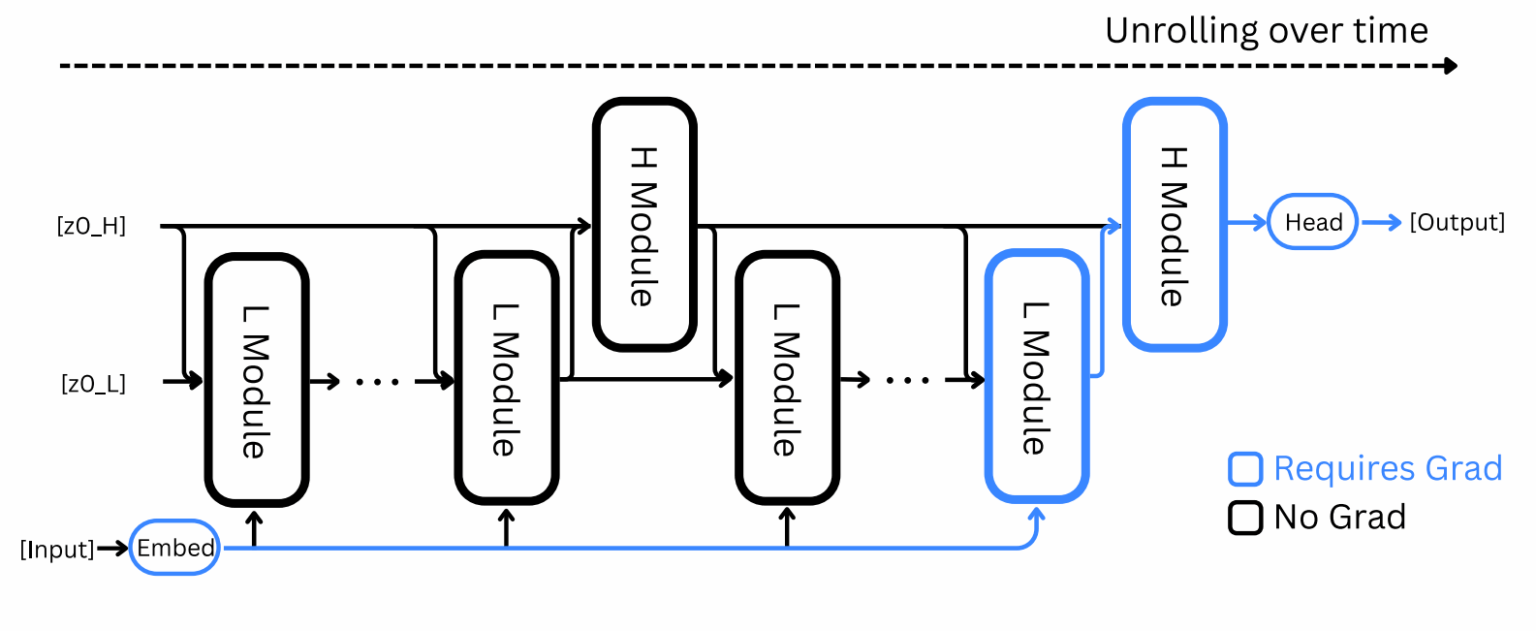

In [3]:
from IPython.display import Image
Image('Fig_8.png', width=400, height=150 )

Post Scriptum: Разбор теоремы к трюку 2.

Пусть мы находимся в окрестности неподвижной точки быстрой модели
$$z^*_L = f_L(z^*_L, z^{k−1}_H , x; θ_L),$$
где $z_L$ - состояние быстрой модели, $z_L$ - медленной,
 $\theta_L$ - параметры быстрой модели, x - проекция входящих данных $X$ линейным слоем к внутренней размерности модели $x = f_I(X, \theta_I)$.

Обновление медленной модели выглядит так
$$z^k_H = f_H(z^{k−1}_H , z^\ast_L; θ_H ) = 
F(z^{k−1}_H ; x, θ),$$
$\theta$ - общий вектор параметров. 

Это все - вектор функции. 


$z^\ast_H = F(z^\ast_H ; x, θ)$ - неподвижная точка медленной модели. $J_F = \partial F/\partial z_H$ - Якобиан.

Предположим, что $I − J_F$ обратима в $z^\ast_
H$, а $F$ непрерывно дифференцируема.
Напишем производную по $\theta$ для $z = F(z, \theta)$:
$$\frac{\partial z}{\partial\theta} = \frac{\partial F}{\partial\theta} + \frac{\partial F}{\partial z}\frac{ \partial z}{\partial \theta}$$

Проведя с этим выражением арифметические операции, получим
$$\frac{\partial z^\ast_H}{\partial\theta} = \left(I - J_F\right)^{-1}\frac{\partial F}{\partial\theta}$$
И, раскладывая эту конструкцию в ряд Неймана https://en.wikipedia.org/wiki/Neumann_series, ограничимся первым приближением. Аналогичные выкладки проведем для $z_L^\ast$.
Таким образом,
$$\frac{\partial z^\ast_H}{\partial \theta_H} \sim \frac{\partial f_H}{\partial \theta_H} 
\quad 
\frac{\partial z^\ast_H}{\partial \theta_L} \sim \frac{\partial f_H}{\partial z^*_L}\frac{\partial z^*_L}{\partial \theta_L} 
\quad
\frac{\partial z^\ast_H}{\partial \theta_I} \sim \frac{\partial f_H}{\partial z^*_L}\frac{\partial z^*_L}{\partial \theta_I}
$$
$$\frac{\partial z^\ast_L}{\partial \theta_L} \sim \frac{\partial f_L}{\partial \theta_L} 
\quad 
\frac{\partial z^\ast_L}{\partial \theta_I} \sim \frac{\partial f_L}{\partial \theta_I}$$ 
откуда,
$$\frac{\partial z^\ast_H}{\partial \theta_L} \sim \frac{\partial f_H}{\partial z^*_L}\frac{\partial f_L}{\partial \theta_L} 
\quad
\frac{\partial z^\ast_H}{\partial \theta_I} \sim \frac{\partial f_H}{\partial z^*_L}\frac{\partial f_L}{\partial \theta_I}$$
значит, нам нужно хранить только финальные градиенты быстрой и медленной модели и без явного back propagation) EPIC WIN
